### Packages Required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import glob
import os
import random
import cv2
from PIL import Image

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet152V2
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Datasets

In [4]:
path = 'C:/Users/Nithin/Downloads/Number Plate Detection/'

In [5]:
file_list = glob.glob(os.path.join(os.getcwd(),path + 'Datasets/Labels' , "*.txt"))

corpus = []
files = []

for file_path in file_list:
    with open(file_path, encoding="latin-1") as f_input:
        corpus.append(f_input.read())
        files.append(''.join([n for n in os.path.basename(file_path) if n.isdigit()]))

df = pd.DataFrame({'file':files, 'text':corpus})

In [6]:
temp_df = df['text'].str.split(expand=True).rename(columns={0:'unkwn',1:'top_x',2:'top_y',3:'bottom_x',4:'bottom_y'})

In [7]:
data = pd.concat([df,temp_df],axis=1)
data.drop(columns=['text','unkwn'],inplace=True)
data.file = data.file + '.jpg'

In [8]:
data.to_csv(path + 'Datasets/data.csv',index=False)

In [9]:
df = pd.read_csv(path + 'Datasets/data.csv')
df

,file,top_x,top_y,bottom_x,bottom_y
0,0.jpg,0.722084,0.587983,0.868486,0.688841
1,1.jpg,0.161943,0.850780,0.582996,1.000000
2,10.jpg,0.311526,0.345000,0.657321,0.547500
3,100.jpg,0.116935,0.299435,0.919355,0.915254
4,101.jpg,0.084677,0.316384,0.915323,0.870056
...,...,...,...,...,...
232,95.jpg,0.314911,0.437956,0.699687,0.556830
233,96.jpg,0.350000,0.551429,0.663333,0.765714
234,97.jpg,0.351429,0.596939,0.631429,0.867347
235,98.jpg,0.104839,0.361582,0.862903,0.836158


In [10]:
test_samp = np.random.randint(0, len(df), 5)
train_samp = df.drop(test_samp, axis=0)

In [11]:
len(test_samp)

5

In [12]:
len(train_samp)

233

### Model Building

In [13]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread(path + 'Datasets/Cars/' + df["file"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

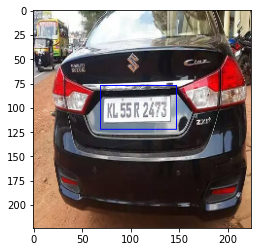

In [14]:
show_img(2)

In [16]:
M0 = Sequential()
M0.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
M0.add(Flatten())
M0.add(Dense(128, activation="relu"))
M0.add(Dense(64, activation="relu"))
M0.add(Dense(64, activation="relu"))
M0.add(Dense(4, activation="sigmoid"))

M0.layers[-6].trainable = False

M0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,938,756
Trainable params: 3,224,068
Non

In [17]:
data = []
for idx, row in train_samp.iterrows():
    img = cv2.resize(cv2.imread(path + 'Datasets/Cars/' + row['file']) / 255.0, dsize=(WIDTH, HEIGHT))
    data.append(img)
data = np.array(data)
data.shape

(233, 224, 224, 3)

In [18]:
train_x, valid_x = data[:210], data[210:]
train_x.shape, valid_x.shape

((210, 224, 224, 3), (23, 224, 224, 3))

In [19]:
adam = Adam(learning_rate=0.0005)
M0.compile(optimizer=adam, loss="mse")

In [20]:
data_y = []
for idx, row in train_samp.iterrows():
    data_y.append([row['top_x'], row['top_y'], row['bottom_x'], row['bottom_y']])
data_y = np.array(data_y)
data_y

array([[0.72208437, 0.58798283, 0.86848635, 0.6888412 ],
       [0.16194332, 0.85077951, 0.58299595, 1.        ],
       [0.31152648, 0.345     , 0.65732087, 0.5475    ],
       [0.11693548, 0.29943503, 0.91935484, 0.91525424],
       [0.08467742, 0.31638418, 0.91532258, 0.8700565 ],
       [0.256     , 0.26241135, 0.722     , 0.71631206],
       [0.11572942, 0.09825328, 0.90383048, 0.37008734],
       [0.47727273, 0.57142857, 0.69545455, 0.6863354 ],
       [0.016     , 0.19039146, 0.92933333, 0.71174377],
       [0.34848485, 0.425     , 0.49545455, 0.56590909],
       [0.11142857, 0.17050691, 0.90285714, 0.87557604],
       [0.06270096, 0.10290237, 0.91157556, 0.89709763],
       [0.08433735, 0.26198083, 0.82730924, 0.5942492 ],
       [0.33984375, 0.49154746, 0.48730469, 0.56827048],
       [0.04666667, 0.28333333, 0.91555556, 0.665     ],
       [0.06625   , 0.29666667, 0.92875   , 0.54166667],
       [0.044     , 0.13333333, 0.998     , 0.96533333],
       [0.02807018, 0.3025    ,

In [21]:
train_y,valid_y = data_y[:210], data_y[210:]

In [22]:
train_y.shape, valid_y.shape

((210, 4), (23, 4))

In [24]:
history = M0.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=30, batch_size=21)

Epoch 1/30
10/10 [==============================] - 64s 6s/step - loss: 0.0450 - val_loss: 0.0169
Epoch 2/30
10/10 [==============================] - 61s 6s/step - loss: 0.0135 - val_loss: 0.0127
Epoch 3/30
10/10 [==============================] - 61s 6s/step - loss: 0.0074 - val_loss: 0.0099
Epoch 4/30
10/10 [==============================] - 61s 6s/step - loss: 0.0046 - val_loss: 0.0096
Epoch 5/30
10/10 [==============================] - 61s 6s/step - loss: 0.0028 - val_loss: 0.0083
Epoch 6/30
10/10 [==============================] - 61s 6s/step - loss: 0.0018 - val_loss: 0.0085
Epoch 7/30
10/10 [==============================] - 61s 6s/step - loss: 0.0011 - val_loss: 0.0073
Epoch 8/30
10/10 [==============================] - 61s 6s/step - loss: 8.3700e-04 - val_loss: 0.0077
Epoch 9/30
10/10 [==============================] - 69s 7s/step - loss: 6.1996e-04 - val_loss: 0.0075
Epoch 10/30
10/10 [==============================] - 78s 7s/step - loss: 4.7277e-04 - val_loss: 0.0074
Epoch 1

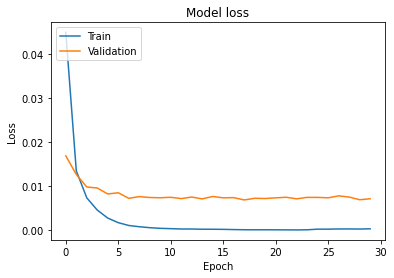

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

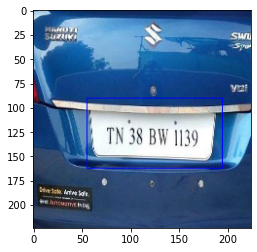

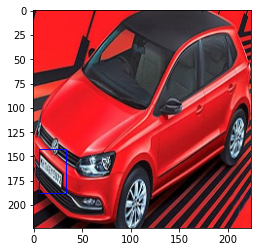

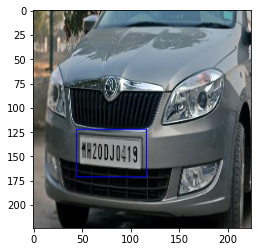

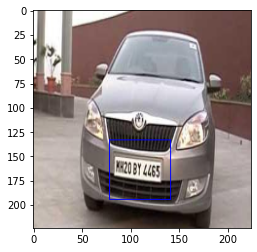

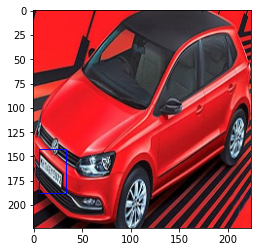

((5, 224, 224, 3), (5, 4))

In [23]:
test_x = []
test_y = []
for idx, row in df.iloc[test_samp].iterrows():
    img = cv2.resize(cv2.imread(path + 'Datasets/Cars/' + row['file']) / 255.0, dsize=(WIDTH, HEIGHT))
    test_x.append(img)
    test_y.append([row['top_x'], row['top_y'], row['bottom_x'], row['bottom_y']])
    show_img(idx)
test_x = np.array(test_x)
test_y = np.array(test_y)
test_x.shape, test_y.shape

In [26]:
M0.evaluate(valid_x, valid_y, batch_size=1)

23/23 [==============================] - 7s 324ms/step - loss: 0.0072


0.007185771595686674

In [27]:
M0.evaluate(test_x, test_y, batch_size=1)

5/5 [==============================] - 2s 320ms/step - loss: 0.0248


0.024762362241744995

In [31]:
pred = M0.predict(test_x)
pred.shape

1/1 [==============================] - 0s 499ms/step


(5, 4)

In [32]:
def show_test_image(img, pred):
    tx = int(pred[0] * WIDTH)
    ty = int(pred[1] * HEIGHT)
    bx = int(pred[2] * WIDTH)
    by = int(pred[3] * HEIGHT)
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


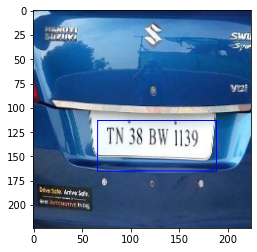

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


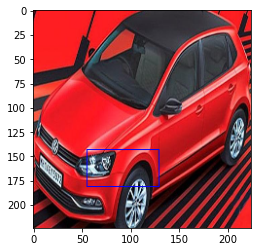

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


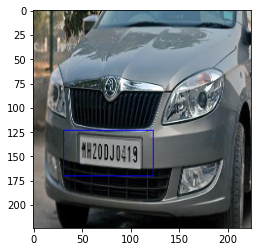

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


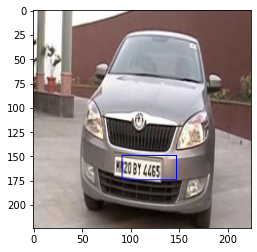

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


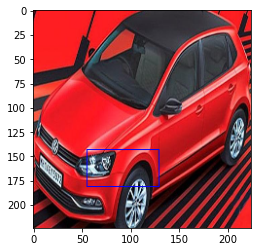

In [34]:
for i in range(0, len(pred)):
    Pred = pred[i]
    img = test_x[i]
    show_test_image(img, Pred)